In [1]:
from scipy import integrate
import pandas as pd
import numpy as np
import noisegen
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.integrate
import matplotlib

In [2]:
# Define a function to calculate the qubit gap as a function of the flux noise.
def delta_gap_func(delta_flux, D=1):
    return delta_flux*D

# Define a function which produces a white noise power spectrum with a UV cutoff.
def psd_func(f, A, f_uv):
    mask = np.abs(f) < f_uv
    return A*mask

According to the thesis of Audrey Cottet (http://www-drecam.cea.fr/drecam/spec/Pres/Quantro, equation 3.13, page 159) over a timescale much shorter that $1/f_\text{UV}$ the dephasing factor is gaussian:

$$
f_\phi(t) = \exp \big( -\frac{1}{2} (2 \pi D t)^2 S^\text{tot} \big)
$$

where $D = \frac{d f_{01}}{ d \lambda}$ is the derivative of the qubit gap in natural frequency units with respect to the noise parameter $\lambda$, and $S^\text{tot} = \int df S(f)$ is the total noise power.

In [9]:
A = 1.0
f_uv = 1.0
seed = 0
cutoff_time = None
n_traces = 2**11
n_frequencies = 10000
f_interval = 0.1

# Initialise the noise generator.
generator = noisegen.NoiseGenerator(n_frequencies, f_interval)

# Take samples of the power spectral density.
psd = psd_func(generator.fft_frequencies, A, f_uv)
generator.specify_psd(psd=psd)

# Generate noise samples.
generator.generate_trace_truncated(seed=seed, n_traces=n_traces, cutoff_time=cutoff_time)

/home/paul/PycharmProjects/noisegen/noisegen/generator.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if psd == 'white':
/home/paul/PycharmProjects/noisegen/noisegen/generator.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif psd == 'pink':
100%|██████████| 2048/2048 [00:07<00:00, 291.04it/s]


In [10]:
# D = derivative of qubit gap in natural frequency units with respect to the noise.
D = 5e0
delta_gap = delta_gap_func(generator.samples, D=D)
phase = 2*np.pi*pd.DataFrame(integrate.cumtrapz(delta_gap,x=delta_gap.index,axis=0),index=delta_gap.index[1:])
coherence = np.exp(1j*phase).mean(axis=1).abs()

In [11]:
# Calculate the total noise power.
def sinc(x):
    return np.sinc(x/np.pi)

def integrand_func(f, t, psd_args=()):
    return sinc(np.pi*f*t)**2 * psd_func(f, *psd_args)

psd_args = (A, f_uv)

integrator_args = (0.0, psd_args)
eps = 1e-9
limit = 50
f_0 = -f_uv
f_1 = f_uv
S_tot = scipy.integrate.quad(integrand_func, f_0, f_1, args=integrator_args, epsabs=eps, epsrel=eps, limit=limit)[0]

def short_time_coherence_func(t, D, S_tot):
    return np.exp(-0.5*S_tot*(2*np.pi*D*t)**2)

short_time_coherence = pd.Series(short_time_coherence_func(coherence.index, D, S_tot), index=coherence.index)

Text(0.5, 0, 'Time')

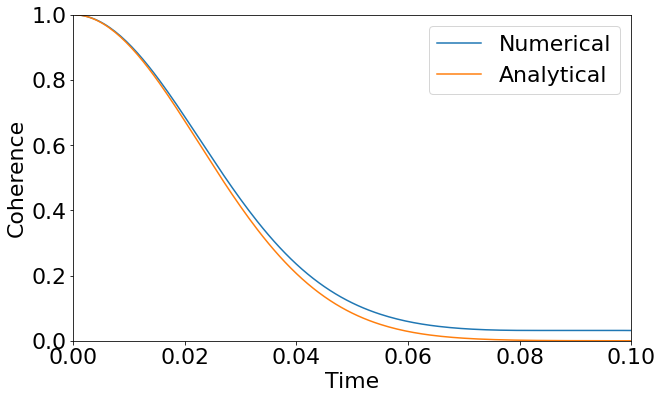

In [12]:
matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

coherence.plot(ax=axes, label='Numerical')
short_time_coherence.plot(ax=axes, label='Analytical')

axes.set_xlim([0,0.1])
axes.set_ylim([0, 1])

legend = axes.legend()
axes.set_ylabel('Coherence')
axes.set_xlabel('Time')

The analytical formula relies on the fact that for a gaussian distributed variable we have

$$
\langle \exp(i \phi(t)) \rangle = \exp(- \frac{1}{2} \langle \phi(t)^2 \rangle)
$$

$$
\phi(t) = 2 \pi D \int_0^t dt^\prime \lambda(t^\prime)
$$

According to equation 3.9 on page 158 this can be calculated according to:

$$
\langle \phi(t)^2 \rangle = (2 \pi t D)^2 \int df S(f) \text{sinc}(\pi f t)^2
$$

At short times $t \ll 1/f_\text{UV}$ the sinc term is approximately uniform over the bulk of the majority of the power spectrum. Therefore the integral reduces to $S^\text{tot}$:
$$
\langle \phi(t)^2 \rangle = (2 \pi t D)^2 S^\text{tot}
$$

Below we can see close agreement between the analyticall and numerically calculated mean square phase.

In [7]:
mean_square_phase = (phase**2).mean(axis=1)
mean_square_phase_analytical = (2*np.pi*mean_square_phase.index*D)**2 * S_tot
mean_square_phase_analytical= pd.Series(mean_square_phase_analytical, index=mean_square_phase.index)

(0.0, 20.0)

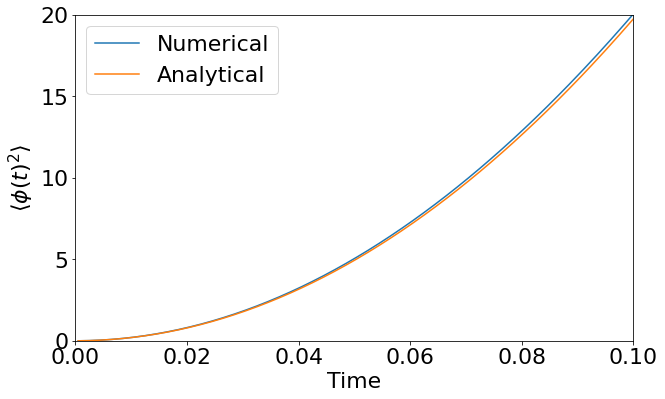

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

mean_square_phase.plot(ax=axes, label='Numerical')
mean_square_phase_analytical.plot(ax=axes, label='Analytical')

axes.set_ylabel(r'$\langle \phi(t)^2 \rangle$')
axes.set_xlabel('Time')

legend = axes.legend()

axes.set_xlim([0,0.1])
axes.set_ylim([0,20])